In [43]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from Utils.build_dataset import paths_dataset
from torchvision import transforms
from Models.linknet_model import linkNet
from Utils.FishDataset import FishDataset
from Utils.training import training_loop, predict, iou_np
from scipy import stats
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import cv2
import os
import sys

In [2]:
dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda:0


In [3]:
label_dict = {0 : "Black Sea Sprat", 1 : "Sea Bass", 2 : "Red Mullet", 3 : "Trout", 4 : "Striped Red Mullet", 
              5 : "Shrimp", 6 : "Red Sea Bream", 7 : "Hourse Mackerel", 8 : "Gilt-Head Bream"}

## Carregando as Imagens

In [4]:
path = 'Dataset/Fish_Dataset/Fish_Dataset/'
df_train_pd, df_valid_pd, df_test_pd = paths_dataset(path)

In [5]:
img_size = 256
classification = True
threshold = 0.5
n_classes = 9
transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((img_size, img_size)), transforms.ToTensor()])

In [6]:
df_train = FishDataset(df_train_pd, transform, transform, classification, img_size)

In [7]:
df_valid = FishDataset(df_valid_pd, transform, transform, classification, img_size)

In [8]:
df_test = FishDataset(df_test_pd, transform, transform, classification, img_size)

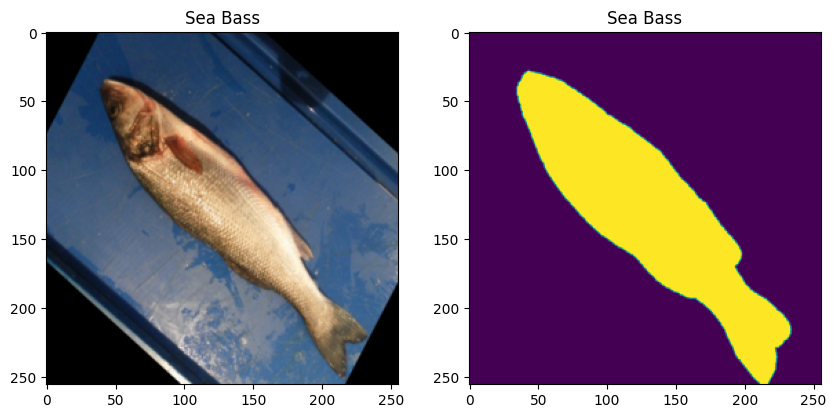

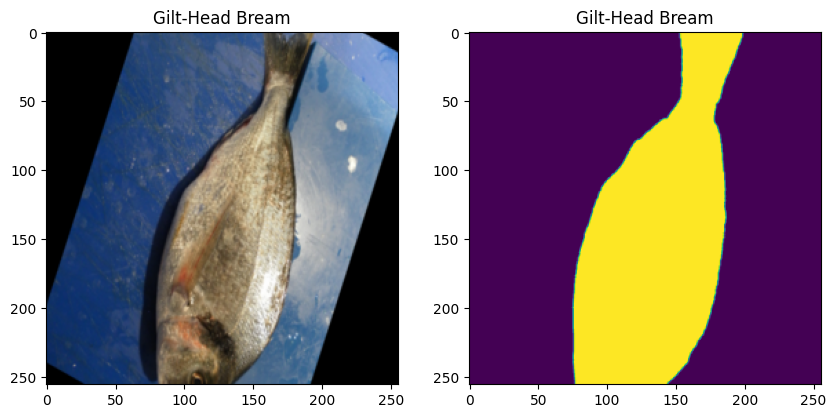

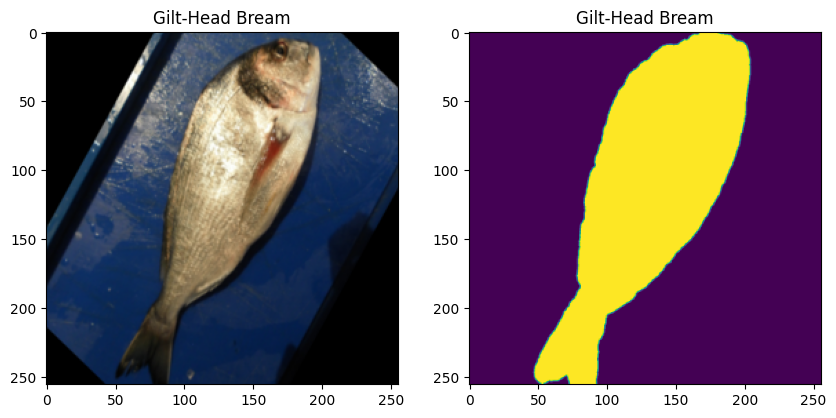

In [9]:
for i in range(3):
    n = random.randint(0, (len(df_train)))
    fig = plt.figure(figsize=(10, 100))
    
    fig.add_subplot(15, 2, 1)
    plt.title(label_dict[df_train[n][2]])
    plt.imshow(df_train[n][0].permute(1, 2, 0))
    
    fig.add_subplot(15, 2, 2)
    plt.title(label_dict[df_train[n][2]])
    plt.imshow(df_train[n][1][df_train[n][2]])

## Construindo o Modelo

In [10]:
model = linkNet(nbClasses = n_classes)
model.to(device, dtype=dtype)

linkNet(
  (_mconv_1): conv_block(
    (_mconv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_block_relu): ReLU(inplace=True)
    )
  )
  (_mmax_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (_mencoder_1): encoder(
    (_mres_1): res_block(
      (_mconv_2): conv_block(
        (_mconv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (_mconv_1): conv_block(
        (_mconv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv_block_relu): ReLU(inplace=True)
        )
      )
      (_mdownsample

In [11]:
epochs = 30
batch_size = 32
lr = 1e-3
train_loader = DataLoader(df_train, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(df_valid, batch_size=batch_size, shuffle=False, num_workers=4)
criterion = torch.nn.BCEWithLogitsLoss()
sigmoid = torch.nn.Sigmoid()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [12]:
len(train_loader.dataset)

5400

In [13]:
model, optimizer, train_losses, valid_losses, train_iou_list, valid_iou_list = training_loop(epochs, model, train_loader, valid_loader, criterion, optimizer, device, dtype)

Epoch 1 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:37<00:00,  1.74it/s]


Train loss: 0.3043	Valid loss: 0.1128	Train IoU: 0.25	Valid IoU: 0.00
Epoch 2 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:29<00:00,  1.90it/s]


Train loss: 0.0844	Valid loss: 0.0722	Train IoU: 0.00	Valid IoU: 0.00
Epoch 3 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:29<00:00,  1.88it/s]


Train loss: 0.0645	Valid loss: 0.0649	Train IoU: 0.00	Valid IoU: 0.00
Epoch 4 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:29<00:00,  1.88it/s]


Train loss: 0.0555	Valid loss: 0.0537	Train IoU: 0.00	Valid IoU: 0.00
Epoch 5 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:29<00:00,  1.89it/s]


Train loss: 0.0493	Valid loss: 0.0647	Train IoU: 0.34	Valid IoU: 0.00
Epoch 6 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:28<00:00,  1.91it/s]


Train loss: 0.0456	Valid loss: 0.0437	Train IoU: 2.39	Valid IoU: 6.88
Epoch 7 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:26<00:00,  1.95it/s]


Train loss: 0.0410	Valid loss: 0.0443	Train IoU: 8.39	Valid IoU: 8.70
Epoch 8 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:28<00:00,  1.91it/s]


Train loss: 0.0347	Valid loss: 0.0521	Train IoU: 21.13	Valid IoU: 11.02
Epoch 9 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:28<00:00,  1.91it/s]


Train loss: 0.0304	Valid loss: 0.0703	Train IoU: 29.15	Valid IoU: 9.83
Epoch 10 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:27<00:00,  1.92it/s]


Train loss: 0.0259	Valid loss: 0.0258	Train IoU: 34.91	Valid IoU: 37.55
Epoch 11 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:27<00:00,  1.93it/s]


Train loss: 0.0235	Valid loss: 0.0353	Train IoU: 39.31	Valid IoU: 30.35
Epoch 12 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:26<00:00,  1.95it/s]


Train loss: 0.0209	Valid loss: 0.0365	Train IoU: 44.88	Valid IoU: 30.17
Epoch 13 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:58<00:00,  2.87it/s]


Train loss: 0.0184	Valid loss: 0.0350	Train IoU: 55.59	Valid IoU: 43.09
Epoch 14 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:36<00:00,  1.75it/s]


Train loss: 0.0156	Valid loss: 0.0173	Train IoU: 68.99	Valid IoU: 68.79
Epoch 15 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:26<00:00,  1.95it/s]


Train loss: 0.0129	Valid loss: 0.0293	Train IoU: 75.69	Valid IoU: 54.97
Epoch 16 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:36<00:00,  1.76it/s]


Train loss: 0.0111	Valid loss: 0.0376	Train IoU: 79.25	Valid IoU: 52.03
Epoch 17 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:36<00:00,  1.74it/s]


Train loss: 0.0094	Valid loss: 0.0813	Train IoU: 82.70	Valid IoU: 24.04
Epoch 18 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:25<00:00,  1.97it/s]


Train loss: 0.0097	Valid loss: 0.0424	Train IoU: 82.18	Valid IoU: 49.43
Epoch 19 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:26<00:00,  1.95it/s]


Train loss: 0.0070	Valid loss: 0.0255	Train IoU: 86.57	Valid IoU: 66.02
Epoch 20 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:03<00:00,  2.65it/s]


Train loss: 0.0086	Valid loss: 0.0096	Train IoU: 83.74	Valid IoU: 84.04
Epoch 21 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:17<00:00,  2.18it/s]


Train loss: 0.0060	Valid loss: 0.0127	Train IoU: 88.14	Valid IoU: 80.46
Epoch 22 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:12<00:00,  2.32it/s]


Train loss: 0.0071	Valid loss: 0.0089	Train IoU: 86.38	Valid IoU: 83.78
Epoch 23 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:01<00:00,  2.75it/s]


Train loss: 0.0056	Valid loss: 0.0077	Train IoU: 88.75	Valid IoU: 87.07
Epoch 24 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:29<00:00,  1.89it/s]


Train loss: 0.0049	Valid loss: 0.0054	Train IoU: 89.72	Valid IoU: 89.31
Epoch 25 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:28<00:00,  1.91it/s]


Train loss: 0.0054	Valid loss: 0.0056	Train IoU: 88.98	Valid IoU: 89.97
Epoch 26 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:31<00:00,  1.85it/s]


Train loss: 0.0049	Valid loss: 0.0074	Train IoU: 89.47	Valid IoU: 86.24
Epoch 27 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:23<00:00,  2.02it/s]


Train loss: 0.0082	Valid loss: 0.0144	Train IoU: 84.53	Valid IoU: 75.37
Epoch 28 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:08<00:00,  2.48it/s]


Train loss: 0.0059	Valid loss: 0.0098	Train IoU: 87.93	Valid IoU: 84.57
Epoch 29 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:59<00:00,  2.86it/s]


Train loss: 0.0053	Valid loss: 0.0045	Train IoU: 88.68	Valid IoU: 90.37
Epoch 30 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:58<00:00,  2.88it/s]


Train loss: 0.0051	Valid loss: 0.0106	Train IoU: 89.16	Valid IoU: 82.79


In [14]:
torch.save(model.state_dict(), "linknet_classification.pkl")

### Carregando Modelo

In [12]:
model.load_state_dict(torch.load("linknet_classification.pkl"))

<All keys matched successfully>

## Avaliando o Modelo

In [15]:
test_loader = DataLoader(df_test, batch_size=batch_size, shuffle=False, num_workers=4)

In [16]:
model.eval()
model.to(device)

linkNet(
  (_mconv_1): conv_block(
    (_mconv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_block_relu): ReLU(inplace=True)
    )
  )
  (_mmax_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (_mencoder_1): encoder(
    (_mres_1): res_block(
      (_mconv_2): conv_block(
        (_mconv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (_mconv_1): conv_block(
        (_mconv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv_block_relu): ReLU(inplace=True)
        )
      )
      (_mdownsample

In [45]:
img_list_test = list(df_test_pd['image'])
mask_list_test = list(df_test_pd['mask'])
label_list_test = list(df_test_pd['label'])
label_id_list_test = list(df_test_pd['label_id'])

In [74]:
running_iou = 0
running_acc = 0

for i in range(len(img_list_test)):
    label_id = label_id_list_test[i]
    image = cv2.imread(img_list_test[i])
    image = cv2.resize(image, (img_size, img_size))
    mask = cv2.imread(mask_list_test[i])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (img_size, img_size))
    pred = predict(model, image, img_size, threshold, device)
    non_zero = np.nonzero(pred)
    pred_label = stats.mode(non_zero[0]).mode
    iou_pred = iou_np(mask, pred[pred_label])
    running_iou += iou_pred
    if pred_label == label_id:
        running_acc += 1

iou_test = (running_iou / len(img_list_test)) * 100
acc_test = (running_acc / len(img_list_test)) * 100

print(f'Accuracy: {iou_test:.1f}')
print(f'IoU: {acc_test:.1f}')

Accuracy: 86.8
IoU: 94.8


Correct Label: Striped Red Mullet
Predicted Label: Striped Red Mullet
IoU: 80.1


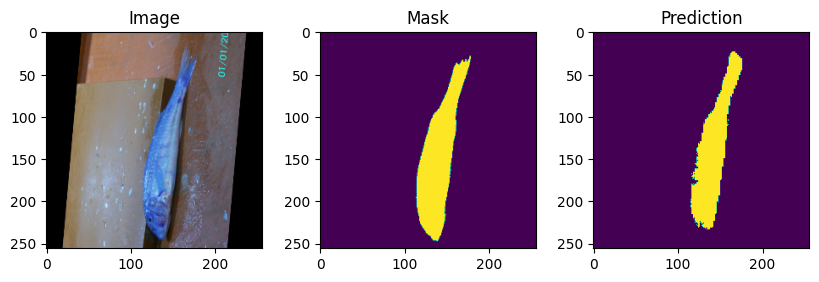

Correct Label: Gilt-Head Bream
Predicted Label: Gilt-Head Bream
IoU: 96.1


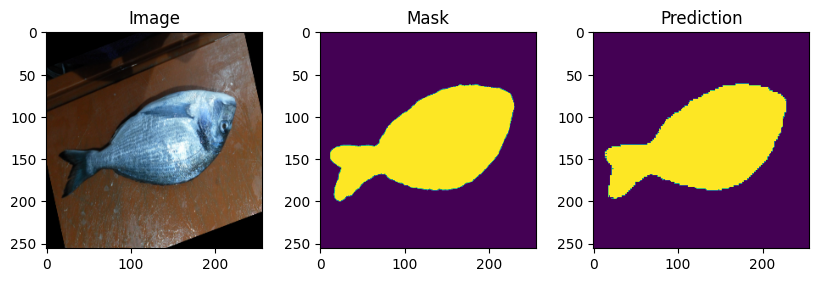

Correct Label: Red Mullet
Predicted Label: Red Mullet
IoU: 91.4


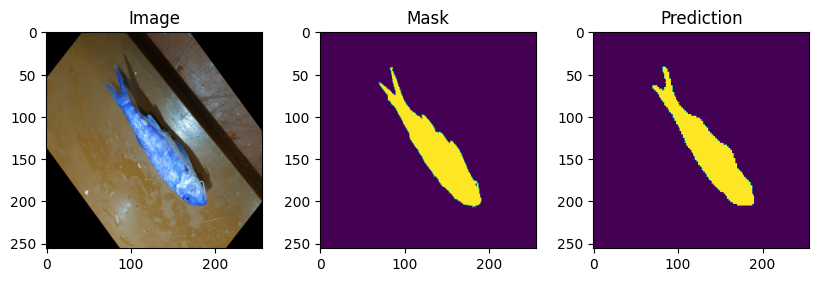

In [75]:
for i in range(3):
    n = random.randint(0, (len(img_list_test)))    
    label = label_list_test[n]
    label_id = label_id_list_test[n]
    image = cv2.imread(img_list_test[n])
    image = cv2.resize(image, (img_size, img_size))
    mask = cv2.imread(mask_list_test[n])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (img_size, img_size))
    pred = predict(model, image, img_size, threshold, device)
    non_zero = np.nonzero(pred)
    pred_label = stats.mode(non_zero[0]).mode
    iou = iou_np(mask, pred[pred_label]) * 100
    
    print(f'Correct Label: {label}')
    print(f'Predicted Label: {label_dict[pred_label]}')
    print(f'IoU: {iou:.1f}')
    
    fig = plt.figure(figsize=(10, 50))
    
    fig.add_subplot(15, 3, 1)
    plt.title('Image')
    plt.imshow(image)
    
    fig.add_subplot(15, 3, 2)
    plt.title('Mask')
    plt.imshow(mask)
    
    fig.add_subplot(15, 3, 3)
    plt.title('Prediction')
    plt.imshow(pred[pred_label])
    
    plt.show()